# Relion comparison

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [37]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=10,10

from src.utils import volume_fourier, mip_x, mip_z, create_mask
from src.projection import project
#from src.interpolate import *

from external.pyem.pyem import star
from external.pyem.pyem.vop import grid_correct
import mrcfile

### The volume

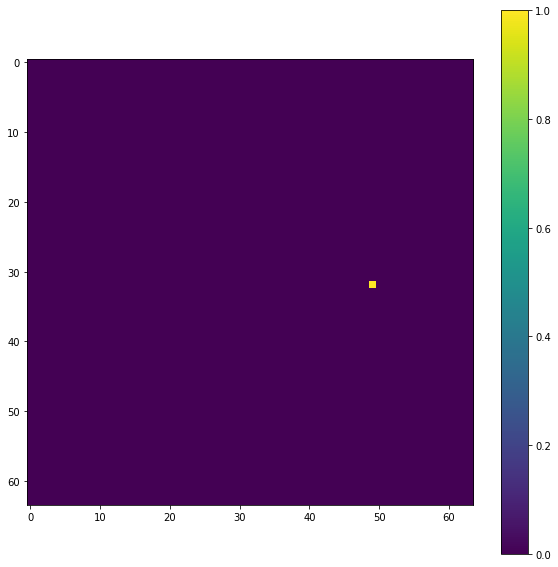

In [98]:
nx = 64
dx = 0.2

vol = np.zeros([nx,nx,nx])
vol[32,49,32] = 1

vol_relion = np.zeros([nx,nx,nx])
vol_relion[32,32,49] = 1

mip_x(vol_relion); plt.colorbar()


### Relion projection

Write the volume to file so it can be processed by Relion

In [99]:
#with mrcfile.new('../data/pointmass.mrc', overwrite=True) as mrc:
#    mrc.set_data(vol_relion.astype(np.float32))

Then start the Relion Singularity instance on a job on the cluster, go to the data directory and run:

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj.mrc --ctf false```

Then load the result:

In [100]:
with mrcfile.open('../data/relion_proj.mrc') as mrc:
    proj_relion = mrc.data

In [101]:
proj_relion

array([[-7.9877663e-04, -1.5483480e-03,  1.6666510e-03, ...,
         1.5050879e-03,  2.1174068e-03,  2.4701641e-03],
       [ 1.6798171e-04,  1.7963620e-03, -1.9438443e-03, ...,
         2.2303428e-04, -3.4152118e-03, -1.4549795e-03],
       [-1.4397312e-03,  2.7766437e-04, -6.8464789e-05, ...,
        -7.3420425e-04,  3.0165282e-03,  2.1318155e-03],
       ...,
       [ 8.8454637e-04, -8.7888046e-05, -5.2221597e-04, ...,
         1.9751563e-04, -2.2005222e-03, -1.9558403e-03],
       [-1.4397312e-03,  2.7766437e-04, -6.8464789e-05, ...,
        -7.3420425e-04,  3.0165282e-03,  2.1318155e-03],
       [ 1.6798171e-04,  1.7963620e-03, -1.9438443e-03, ...,
         2.2303428e-04, -3.4152118e-03, -1.4549795e-03]], dtype=float32)

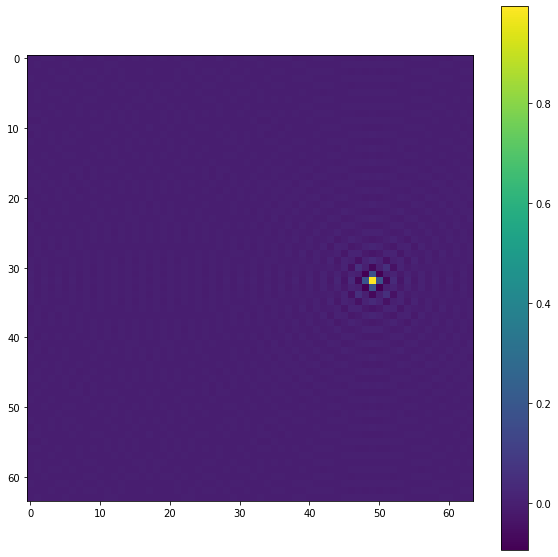

In [102]:
plt.imshow(proj_relion); plt.colorbar()

### My projection

In [103]:
pixel_size = 1 #star.calculate_apix(p) * 64.0/66.0

vol = grid_correct(vol, pfac = 1, order = 1)

f3d, X, Y, Z = volume_fourier(np.fft.ifftshift(vol), pixel_size)


#mymask = create_mask(X,Y,Z, (0,0,0), np.max(X))
#f3d = f3d * mymask

x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

# IMPORTANT: do not make this a Jax array
x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

angles = [0,0,0] # third angle is rotation around the first z axis
shifts = [0.0, 0.0]

In [104]:
f2d, coords_slice = project(f3d, x_grid, y_grid, z_grid, angles, shifts, 'tri', None)
f2d = f2d.reshape(f3d.shape[0], f3d.shape[1])
#f2d = np.fft.fftshift(f2d)
proj = np.real(np.fft.fftshift(np.fft.ifftn(f2d)))

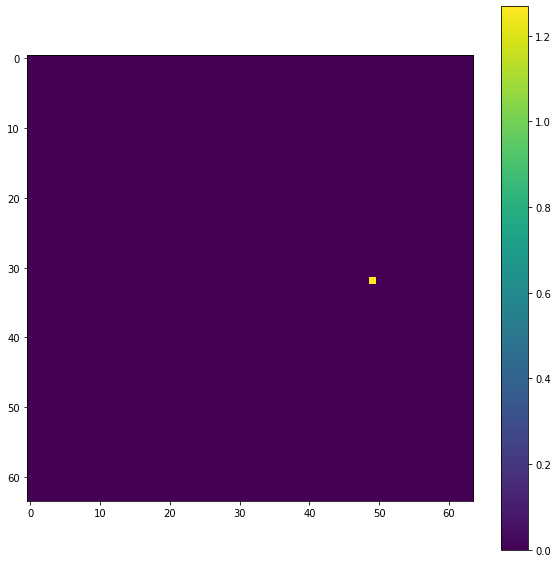

In [105]:
plt.imshow(proj); plt.colorbar()

### Compare

In [106]:
f2d_relion = np.fft.fftshift(np.fft.fftn(proj_relion))
f2d = np.fft.fftshift(np.fft.fftn(proj))

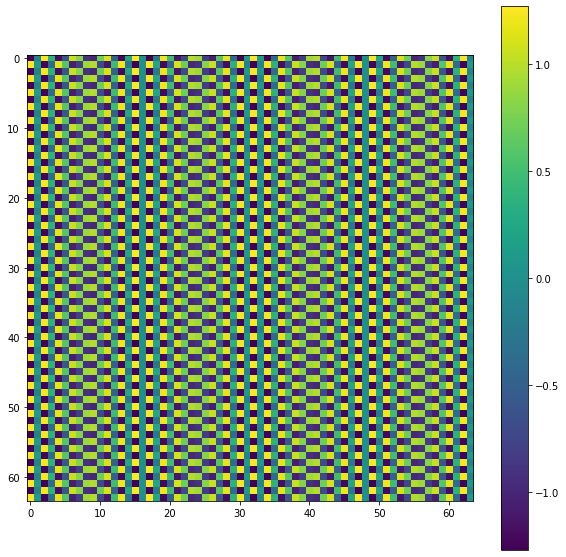

In [107]:
plt.imshow(np.real(f2d)); plt.colorbar()

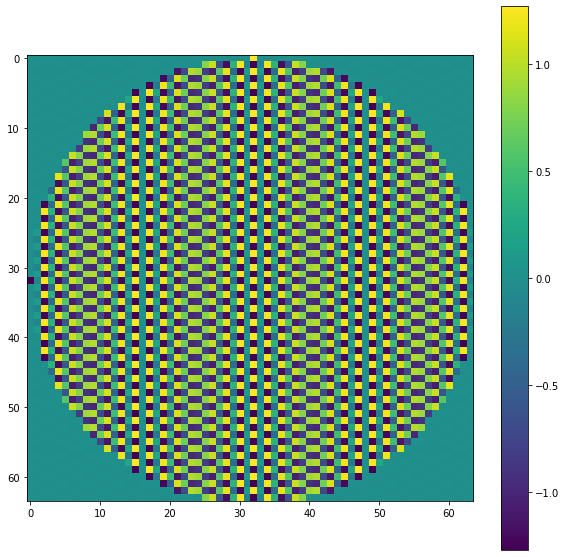

In [108]:
plt.imshow(np.real(f2d_relion)); plt.colorbar()

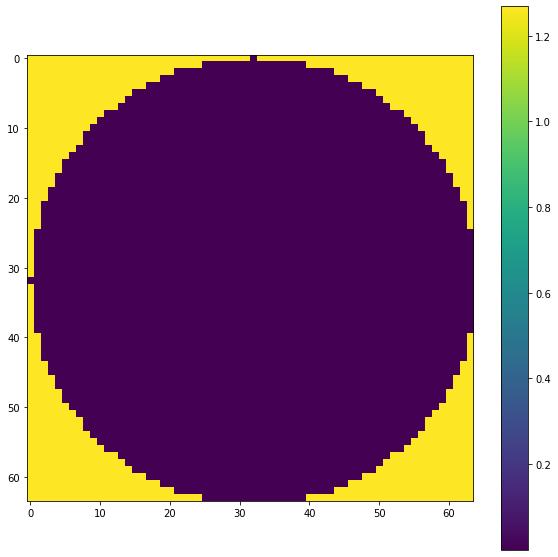

In [112]:
diff = f2d - f2d_relion
plt.imshow(np.abs(diff)); plt.colorbar()

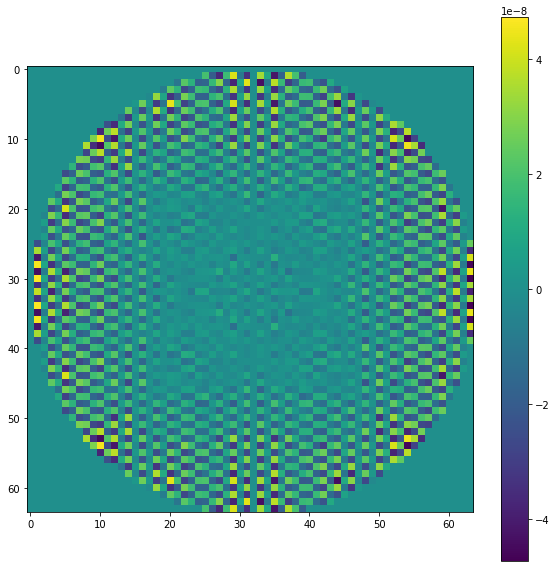

In [113]:
diff[np.abs(diff) > 1] = 0
plt.imshow(np.imag(diff)); plt.colorbar()